In [22]:
import operator
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import Send
from pydantic import BaseModel, Field
from typing_extensions import Annotated, List, TypedDict
from module import get_module

In [23]:
module_client = get_module()

In [24]:
class Section(BaseModel):
    name: str = Field(description="章节标题")
    description: str = Field(description="章节概述")

class Sections(BaseModel):
    sections: List[Section] = Field(description="论证文章的各个字章节")

planner = module_client.with_structured_output(Sections)

In [25]:
output = planner.invoke("论证主题：AI时代需要学习编程，将这个论证分拆成几个不同的立场进行对焦度分析。")

In [26]:
output.sections

[Section(name='技术需求', description='现代社会中编程是满足技术开发与问题解决的基础技能。'),
 Section(name='职业竞争', description='掌握编程技能可以提高个人的职业竞争力与发展潜力。'),
 Section(name='跨学科融合', description='编程为其他领域的研究与创新提供工具支持，实现知识的融合与推进。'),
 Section(name='个人兴趣与创造力', description='学习编程能激发个人创造力，开发有趣的个人项目或解决生活中的问题。'),
 Section(name='社会普及与认知', description='编程作为一种现代技术，了解其原理有助于更好地理解我们所处的技术化社会。')]

In [27]:
# Graph state
class State(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: Annotated[list, operator.add] # All workers write to this key in parallel
    final_report: str

class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [28]:
def orchestrator(state: State):
    output = planner.invoke([
        SystemMessage(content="你需要分析论证某个主题，并将其分拆成几个不同的立场进行多视角分析。"),
        HumanMessage(content=f"论证主题：{state['topic']}")
    ])

    return { "sections": output.sections }

In [29]:
def complete_section(state: WorkerState):
    output = module_client.invoke([
        SystemMessage(content="根据提供的章节标题和章节概述，完成论证文章的其中一个章节。用中文来写。"),
        HumanMessage(content=f"章节标题为：${state['section'].name} 章节概述为: ${state['section'].description}")
    ])
    return { 'completed_sections': [output.content] }

In [30]:
def synthesizer(state: State):
    completed_sections = state['completed_sections']
    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    return { 'final_report': completed_report_sections }

In [31]:
# Conditional edge function to create complete_section works that each write a section of the report
def assign_workers(state: State):

    # Kick off section writing in parallel via Send() API
    return [Send("complete_section", { 'section': s }) for s in state['sections']]

In [32]:
orchestrator_worker_builder = StateGraph(State)

orchestrator_worker_builder.add_node('orchestrator', orchestrator)
orchestrator_worker_builder.add_node('complete_section', complete_section)
orchestrator_worker_builder.add_node('synthesizer', synthesizer)

orchestrator_worker_builder.add_edge(START, 'orchestrator')
orchestrator_worker_builder.add_conditional_edges('orchestrator', assign_workers, ['complete_section'])
orchestrator_worker_builder.add_edge('complete_section', 'synthesizer')
orchestrator_worker_builder.add_edge('complete_section', END)

orchestrator_worker = orchestrator_worker_builder.compile()

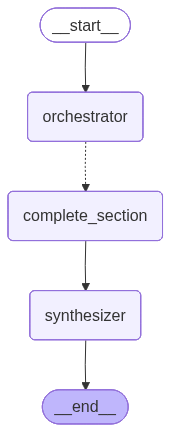

In [33]:
from IPython.display import display, Image

display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [34]:
state: State = orchestrator_worker.invoke({ 'topic': "AI时代需要学习编程" })

In [35]:
state['sections']

[Section(name='AI技术的广泛应用', description='进入AI时代，各种自动化、智能化技术成为社会和经济的重要组成部分。学习编程能够帮助人们更好地理解和参与AI时代进步的浪潮。'),
 Section(name='编程能力的职业影响', description='随着AI和技术驱动的行业增长，编程能力成为许多职业必备技能，学习编程为个人职业发展提供优势。'),
 Section(name='编程学习促进思维发展', description='编程不仅是一种技术工具，它还培养了解决问题的能力和逻辑思维，对个人发展有积极影响。'),
 Section(name='对非技术人士的观点', description='虽然并非每个人都需要深入学习编程，但对基本编程概念和逻辑的理解可以提升生活技能和管理智慧。')]

In [36]:
state['completed_sections']

['### AI技术的广泛应用\n\n进入AI时代，人工智能技术早已不再局限于实验室和科研领域，而是以广泛而深远的方式渗透进社会的各个角落，从日常生活到工业生产，再到医疗、教育等公共服务领域，AI技术成为驱动社会和经济发展的强大引擎。\n\n在日常生活中，AI已经无处不在。智能家居通过语音助手实现了生活的便捷化，而个性化推荐算法让人们的购物体验更加精准。比如，音乐和视频流媒体平台通过AI分析用户的观影或听歌记录，提供个性化推荐，节省了用户大量的筛选时间。同时，AI技术对于出行也带来了革命性的改变。自动驾驶技术的出现，让人们看到了更安全、更高效、更环保的交通方式。这些依托AI的应用不仅优化了需求匹配与资源管理，也为普通人腾出了更多的精力用于享受生活。\n\n在经济领域，AI推动了企业运作方式的彻底革新。从智能生产线上的机器手到商业决策支持平台，AI帮助企业提高了生产效率，同时也通过数据分析挖掘商业价值，优化市场策略。例如，通过机器学习算法，企业可以预测市场趋势，发现潜在消费者，并制定合理的产品销售计划，从而提升了市场竞争力。与此同时，农牧业也在人工智能的帮助下实现了智能化转型。基于机器视觉和传感器技术的农田监控系统可以精准识别作物健康状况和病害，而无人机技术与AI结合则让农作物管理更加高效。\n\n公共服务领域内，AI也在悄无声息地改变我们的生活。一方面，它通过医疗技术的突破性创新改善了人类健康。例如，基于深度学习的图像分析能够帮助医生识别癌症等疾病，大幅提高诊断效率；另一方面，教育领域的智能化学习平台，利用AI算法个性化分析每个学生的学习进展，为学生提供独特的学习路径，极大地提高了教学效果。在疫情防控中，智能追踪系统利用人群移动数据与症状报告协助防疫决策，这些技术也充分展示了AI技术服务公共健康的潜力。\n\n然而，要全面领悟并掌握这些改变社会的力量，学习编程和掌握AI相关技术成为现代社会必不可少的能力之一。学习编程不仅能帮助人们理解人工智能技术的运行机制，还能为他们奠定进入科技领域的基础，进而主动参与AI时代的创新发展。编程语言是沟通人与机器的桥梁，它让人们能够创造符合自己需求的智能解决方案，成为数字时代的“生产者”，而不只是信息技术的“消费者”。更重要的是，编程与AI技术学习相辅相成，能够提升个人独立解决问题的能力和创新能力，让人们不再局限于现有技术，而是探索它

In [37]:
from IPython.display import Markdown
Markdown(state['final_report'])

### AI技术的广泛应用

进入AI时代，人工智能技术早已不再局限于实验室和科研领域，而是以广泛而深远的方式渗透进社会的各个角落，从日常生活到工业生产，再到医疗、教育等公共服务领域，AI技术成为驱动社会和经济发展的强大引擎。

在日常生活中，AI已经无处不在。智能家居通过语音助手实现了生活的便捷化，而个性化推荐算法让人们的购物体验更加精准。比如，音乐和视频流媒体平台通过AI分析用户的观影或听歌记录，提供个性化推荐，节省了用户大量的筛选时间。同时，AI技术对于出行也带来了革命性的改变。自动驾驶技术的出现，让人们看到了更安全、更高效、更环保的交通方式。这些依托AI的应用不仅优化了需求匹配与资源管理，也为普通人腾出了更多的精力用于享受生活。

在经济领域，AI推动了企业运作方式的彻底革新。从智能生产线上的机器手到商业决策支持平台，AI帮助企业提高了生产效率，同时也通过数据分析挖掘商业价值，优化市场策略。例如，通过机器学习算法，企业可以预测市场趋势，发现潜在消费者，并制定合理的产品销售计划，从而提升了市场竞争力。与此同时，农牧业也在人工智能的帮助下实现了智能化转型。基于机器视觉和传感器技术的农田监控系统可以精准识别作物健康状况和病害，而无人机技术与AI结合则让农作物管理更加高效。

公共服务领域内，AI也在悄无声息地改变我们的生活。一方面，它通过医疗技术的突破性创新改善了人类健康。例如，基于深度学习的图像分析能够帮助医生识别癌症等疾病，大幅提高诊断效率；另一方面，教育领域的智能化学习平台，利用AI算法个性化分析每个学生的学习进展，为学生提供独特的学习路径，极大地提高了教学效果。在疫情防控中，智能追踪系统利用人群移动数据与症状报告协助防疫决策，这些技术也充分展示了AI技术服务公共健康的潜力。

然而，要全面领悟并掌握这些改变社会的力量，学习编程和掌握AI相关技术成为现代社会必不可少的能力之一。学习编程不仅能帮助人们理解人工智能技术的运行机制，还能为他们奠定进入科技领域的基础，进而主动参与AI时代的创新发展。编程语言是沟通人与机器的桥梁，它让人们能够创造符合自己需求的智能解决方案，成为数字时代的“生产者”，而不只是信息技术的“消费者”。更重要的是，编程与AI技术学习相辅相成，能够提升个人独立解决问题的能力和创新能力，让人们不再局限于现有技术，而是探索它的前沿。

总的来看，AI技术的广泛应用深刻地改变了社会生活与经济运作的方式，其正以前所未有的速度扩展至各个领域。然而，这也对现代人的技能和认知提出了新的要求。通过学习编程与掌握相关技术，人们能够更好地适应这一发展趋势，不仅成为技术变革的受益者，更能成为推动技术进步的中坚力量。在AI时代中，我们不仅是见证者，更应该是创新的参与者。

---

### 编程能力的职业影响

随着全球技术的飞速发展和人工智能驱动的浪潮，编程能力已经从少数技术从业者的专业技能，逐渐转变为许多领域的核心能力。无论是软件开发、数据分析，还是自动化操作、产品管理，编程技能的作用正迅速扩展到各个行业，成为提高职场竞争力的重要工具。

首先，编程能力为工作效率的提升提供了新的可能。许多职业日常涉及重复性任务或大量数据处理，通过编写代码实现自动化，不但能节省时间，还能减少人为操作的出错几率。例如，金融行业的专业人士可以通过编程自动化生成财务报告，市场营销人员可以用代码分析消费者行为，甚至在行政职位上，员工也能通过简单的脚本快速整理和筛选数据。这种能力的应用，使得拥有编程技能的员工更高效、更精准，无形中成为公司内的高价值人才。

其次，编程能力为个人职业生涯的多元化发展铺平了道路。在传统路径中，许多职位的技能需求常常是单一的，且彼此间差异性较大。然而，编程能力在多个领域都存在广泛的应用需求。例如，AI行业需要编程建模统计，游戏开发需要编程整合图像与代码，甚至连教育与艺术等看似与技术不相关的领域，也开始借助编程实现创作与教学创新。这种技能的可迁移性，为具有编程能力的从业者打开了更多选择和机会。

此外，编程技能还在推动职业发展过程中扮演关键角色，为个人建立更强的技术“护城河”。在当今数据驱动、智能化转型的社会中，企业不仅仅关注个人的传统经验，也逐渐青睐能够在技术变革中引领发展的专业人才。掌握编程技能意味着个人能够适应并引导复杂的技术系统，例如自动化系统的搭建、智能化工具的应用等，这使得编程成为提升个人话语权与职业站位的强大助力。

不得不提的是，人工智能和大数据的蓬勃发展使得编程成为赋予个人可持续学习能力的重要途径。很多技术领域不断迭代更新，不具备基本编程技能的人难以跟上技术进步的节奏。而对于懂编程的从业者来说，通过代码和开源资源，他们可以更快地学习新工具、新框架，从而保持知识的前沿性，确保自己的职业竞争力。与其被动适应行业趋势，不如主动通过编程能力占据更有利的职场地位。

总之，编程能力在今后的职业发展中不再是锦上添花的“技能加分项”，而是逐步转变为核心竞争力的重要组成部分。无论是在提升效率、拓展多元化职业领域、增强个人竞争力还是实现自我可持续学习方面，编程能力都扮演着不可替代的作用。因此，对于处在职业起步阶段或希望职业转型的人群，学习并掌握一定的编程技能无疑是顺应大势、实现自我价值的重要手段。

---

### 编程学习促进思维发展

在当今数字化时代，编程已成为一种重要技能，不论是成年人还是青少年都积极投入到编程学习中。然而，编程的价值不仅仅体现在掌握技术工具或开发程序上，更深层次的意义在于它对个人思维的塑造与发展。通过学习编程，个人能够培养解决问题的能力、提升逻辑思维，并从中获得全方位的成长。

#### 编程带来的问题解决能力

编程的核心在于解决问题。从初步学习编写代码到开发复杂的软件系统，每一步都离不开一连串问题的分析与解决。学习编程时，程序可能因为一个错误而无法运行，面对这些错误，学习者需要分析问题根源，寻找解决办法。这种过程培养了面对问题时冷静分析的能力，同时也激发了创新思维。例如，在编程时，理解算法的优化过程要求学习者将目标拆解成具体步骤，寻求最优方案。这种拆解问题的能力不仅适用于编程，还能够迁移到其他领域，如学术研究、工作项目以及日常生活中常见的复杂情况。

#### 培养逻辑思维的有效途径

逻辑思维是一种通过分析和推理来做出最佳决策的能力，而编程学习恰恰能够强化这一技能。编程的本质依赖于逻辑规则，无论是条件判断（if-else）还是循环结构（for、while），都要求学习者能够逻辑清晰地思考问题。例如，要编写一个简单的计算器程序，学习者需要梳理出用户输入数字、识别运算符、完成结果输出的整个过程。这种层层递进、步步细化的思维方式能够使人逐步摆脱直觉思维的局限，将问题或任务分解为清晰的逻辑步骤，从而提高思维效率。

#### 激发创造力与开放性思维

虽然编程以逻辑为基石，但它同时也是创造力的沃土。编程语言为人们提供了一个表达思想和创意的平台。通过编程，可以制作游戏、设计应用程序，甚至可以开发人工智能模型，这些都需要充分应用想象力和创造力。在解决实际问题时，编程者常常需要打破常规，尝试新的方法，这种开放性思维在编程实践中表现得尤为明显。例如，设计一种购物网站的推荐算法不仅要求准确分析顾客行为，还需要独特的创意来增加用户体验。

#### 对个人发展的综合影响

编程学习不仅帮助学习者提升技术能力，更能够对个人发展产生深远影响。编程要求专注、耐心以及对学习的主动性，长期的编程学习能够培养强大的自我管理和毅力。尤其是面对复杂的项目时，学习者需要制定计划、分配任务并实现目标，这些技能会促进个人未来在其他领域的成功。此外，随着数字化改革的推进，编程已经成为许多行业的通用语言，掌握编程不仅提升职业竞争力，还帮助个人适应现代社会技术变革的挑战。

综上所述，编程绝不仅仅是一门技术工具，它是一种促进思维发展的强大手段。通过开发解决问题能力、培养逻辑思维、激发创造力以及提升个人综合素养，编程学习为个人的发展注入了新的可能性。无论出于兴趣还是职业发展需求，持续学习编程都是一种投资，也是一种成长的方式，在塑造思维的同时，让学习者更好地应对未来中的未知挑战。

---

### 对非技术人士的观点

在现代社会中，编程日益成为一种通用语言，贯穿于科技、商业甚至日常生活的各个方面。尽管并非每个人都需要精通编程，成为专业的开发者，但对基本的编程概念和逻辑的理解无疑可以为非技术人士提供不可忽视的优势。学习编程不仅仅是掌握一门技能，更是一种思维方式的拓展，其对生活技能的优化和问题解决能力的提升具有重要意义。

**首先，编程逻辑可以培养高效的问题解决能力，它适用于生活中的各种场景。** 编程本质上是解决问题的过程，这一过程包括识别问题、分析问题、规划解决方案以及优化执行结果。这种系统性的思维方式能够帮助普通人在生活和工作中更高效地应对挑战。例如，对于复杂的工作任务，一个拥有编程逻辑思维的人可能会更善于归纳和拆解任务，并制定出具体可行的步骤，而不是陷入混乱和拖延。

**其次，基本编程概念的掌握能提升信息管理能力和数据素养。** 当今时代，数据无处不在，而善于整理和分析数据是个人和企业高效决策不可缺少的能力。尽管非技术人士可能不需要写复杂的代码，但懂得如何使用简单的自动化工具或者编写基本的数据筛选代码，就能在日常生活中如鱼得水。例如，会用简单的Excel公式或者脚本来整理预算，可以让家庭财务安排更加科学仔细；懂得如何利用线上工具整理客户反馈，则能让小型创业者做出更精准的市场判断。

**另外，了解编程还能改善沟通能力，尤其在技术与非技术领域之间的桥梁角色中。** 在公司团队中，技术人员与非技术人员之间经常需要协同合作，但由于语言或背景的差异，双方之间往往容易出现沟通障碍。如果非技术人员对编程有基本的认知，就能更好地理解技术团队的语言，从而提高沟通效率。这不仅能加强团体合作，还能避免许多因误解而导致的资源浪费和错误决策。

**更重要的是，学习编程带来的逻辑思维和创新意识，对个人长期发展有深远影响。** 通过熟悉编程逻辑，个人更容易培养结构化的思考方式，而这种能力不仅适用于工作，也能在生活中发挥作用。例如，在规划生活项目、控制时间或设计策略时，这种系统的、条理清晰的思考过程能让我们站在更高的视角看待问题，从而做出更优质的选择。

当然，我们也需要认识到，鼓励每一个非技术人士学习编程，并非意味着每个人都要达到专业的程序员水平。更现实、也更有意义的目标，是帮助每个人理解编程的一些基础原理，如逻辑判断、流程控制和基本算法。这些知识虽然简单，但其背后的思维模式却能渗透到生活的方方面面。

总而言之，编程作为一门日益普及的“工具性语言”，对于非技术人士来说，不必担忧成为某种精深的学术挑战，而应当视其为一种提升自身生活品质与工作能力的实用技能。通过对基本编程概念和逻辑的掌握，非技术人士不仅能够适应快速变化的社会环境，还能在生活和事业中获得更多主动权。编程能力虽然起初听起来离普通人很远，但从长远来看，掌握了它反而更能拉近人与技术世界的距离。